# Import Libraries

In [16]:
import numpy as np
import cv2
import random
import time
import math
import matplotlib.pyplot as plt

In [17]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from gym import spaces

# Helper Functions

In [18]:
#functionss
def collision_landing_pad(landing_pad_position, score):
    terminate = True
    score += 10
    return score, terminate

def out_of_frame(rocket_position):
    if rocket_position[0]>=1920 or rocket_position[0]<0 or rocket_position[1]>=1080 or rocket_position[1]<0 :
        return 1
    else:
        return 0
    
def rk4_e(f, y, h, t, *args):
    # runge kutte 4th order explicit
    tk_05 = t + 0.5*h
    yk_025 = y + 0.5 * h * f(t, y, *args)
    yk_05 = y + 0.5 * h * f(tk_05, yk_025, *args)
    yk_075 = y + h * f(tk_05, yk_05, *args)
    
    return y + h/6 * (f(t, y, *args) + 2 * f(tk_05, yk_025, *args) + 2 * f(tk_05, yk_05, *args) + f(t+h, yk_075, *args))

def scaling(pos_x, pos_y, width, height, uncovered=0.1):
    # scale flight path to frame

    # uncovered is part of frame that is not used to visualize flight path
    used_width = int(width * (1 - 2*uncovered))
    used_height = int(height * (1 - 2*uncovered))
    
    max_pos_x = max(pos_x)
    min_pos_x = min(pos_x)
    max_pos_y = max(pos_y)
    min_pos_y = min(pos_y)
    
    dist_x = max_pos_x - min_pos_x
    dist_y = max_pos_y - min_pos_y
    
    if dist_x>=dist_y:
        max_dist = dist_x + 1
    else:
        max_dist = dist_y + 1
    
    scaled_x = used_width/(max_dist)*pos_x
    scaled_x = scaled_x - (min(scaled_x) - int(uncovered*width))
    
    scaled_y = used_height/(max_dist)*pos_y
    scaled_y = scaled_y - (min(scaled_y) - int(uncovered*width))
    scaled_y = height - scaled_y
                           
    return scaled_x.astype(np.int32), scaled_y.astype(np.int32)

def rotation(phi, points):    
    x_rotate = points[:,0] * np.cos(phi) - points[:,1] * np.sin(phi)
    y_rotate = points[:,0] * np.sin(phi) + points[:,1] * np.cos(phi)
    
    return np.array([x_rotate, y_rotate]).T.astype(np.int32)

# Custom Environment

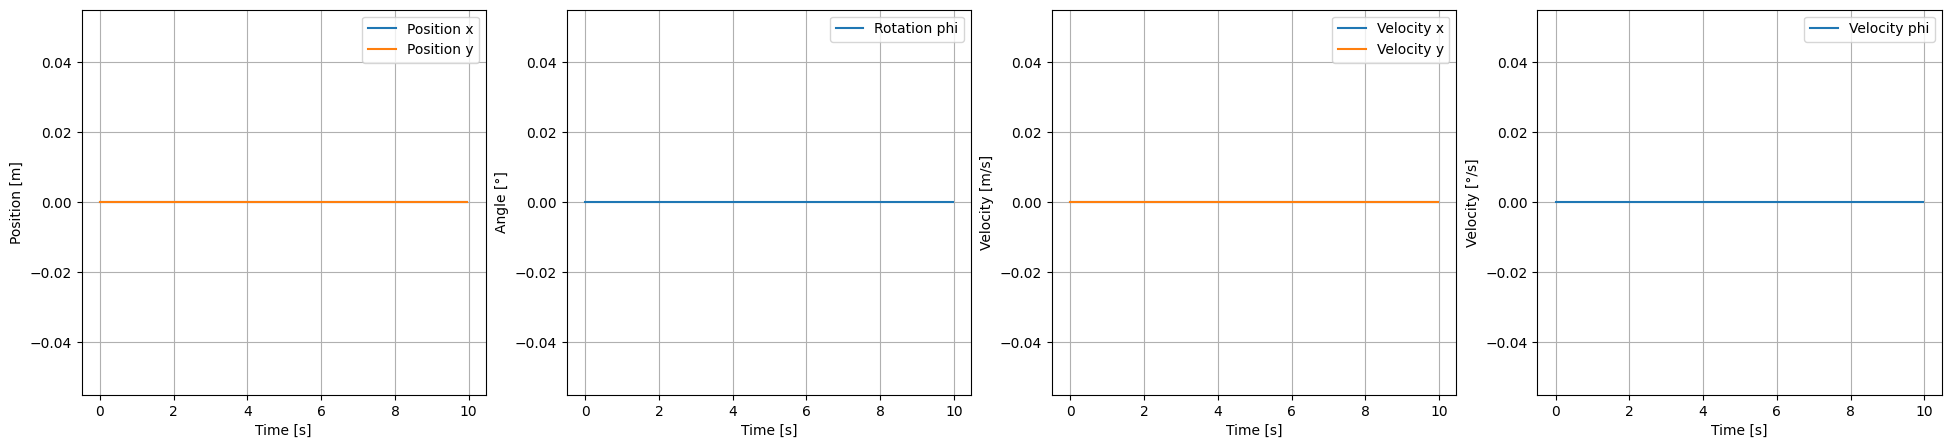

In [19]:
g = 1.625                   # m/s^2
m = 1000                    # mass of the spacecraft in kg
Theta = 1000                # moment of inertia of the spacecraft
b = 2                       # distance of thrust vector from center of gravity --> check the handout for the sketch
a = 1                       # distance of thrust vector from center of gravity --> check the handout for the sketch

h = 1/30   # time step size
t0 = 0                  # initial time
tn = 10                 # end time
number_of_time_steps = (tn-t0)/h # number of time steps
linear = True           # using linear (True) or nonlinear equations of motion (False)

x0 = 250                # initial x position
y0 = 350                # initial y position
phi0 = math.radians(-15) # initial rotation angle of spacecraft (mathematically positive defined)
velx0 = -25             # initial x direction velocity (u)
vely0 = -25             # initial y direction velocity (v)
velphi0 = 0             # initial z direction velocity (w)

alpha_beta_rate = math.radians(22.5)
thrust_rate = 200

time = np.linspace(t0, tn, int((tn-t0)/h)+1)

states = np.zeros((6, len(time)))

# data coming from 2D_flight_dynamic_propagation.py
pos_x = states[0,:-1]#.astype(np.int32)
pos_y = states[1,:-1]#.astype(np.int32)

phi = -states[2,:-1] # negative sign, because rotation matrix is defined incorrelty with regard to mathematical positive rotation

vel_x = states[3,:-1]
vel_y = states[4,:-1]

alpha = 0
beta = 0

max_thrust = 1500

T_l = 0
T_r = 0
T_c = 1625 * 1.2

In [20]:
class SpacecraftEnv(gym.Env):
    """Custom Environment that follows gym interface."""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        gravity: float = -9.81,
        mass: float = 1000.0,
        moment_inertia: float = 1000.0,
        thrust_vector_x: float = 2.0,
        thrust_vector_y: float = 1.0,
        alpha_beta_rate = 0):
        
        super().__init__()
        
        #rocket initial data
        self.gravity = gravity
        self.mass = mass
        self.moment_inertia = moment_inertia
        self.rocket_position = [250, 350] #vec2 position
        self.rocket_velocity = [-25, -25] #vec2 velocity
        self.rocket_accel = [0, 0]
        
        self.rocket_angle = 0 #float angle
        self.rocket_angular_vel = 0 #float angular velocity
        self.rocket_angular_accel = 0
        self.is_touching_pad = False #bool is_touching_pad
        
        #landing pad initial data
        self.pad_position = [0, 0] #vec2 position
        self.pad_width = 5 #float width
        self.pad_height = 2 #float height
        
        #rocket side engines
        self.alpha = 0
        self.beta = 0
        self.alpha_beta_rate = alpha_beta_rate
        self.thrust_dynamic = 200
        
        self.thrust_left = 0
        self.thrust_right = 0
        self.thrust_center = mass * gravity * 1.2
        
        # thrust engines (3)
        # control alpha beta
        self.action_space = spaces.Box(-1, 1, (5,), dtype='int8')
        
        low = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                -1.5,
                -1.5,
                # velocity bounds is 5x rated speed
                -5.0,
                -5.0,
                -math.pi,
                -5.0,
                -0.0,
                -0.0,
            ]
        ).astype(np.float32)
        high = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                1.5,
                1.5,
                # velocity bounds is 5x rated speed
                5.0,
                5.0,
                math.pi,
                5.0,
                1.0,
                1.0,
            ]
        ).astype(np.float32)
        
        self.observation_space = spaces.Box(low, high)

    def step(self, action):
        #CALCULATION
        #update xy
        
        
        force_accumulation = thrust_center + alpha * thrust_right + beta * thrust_left
        self.rocket_accel = force_accumulation / self.rocket_mass
        
        
        
        
        
        
        if tn == self.t_fail:
            match self.failure_case:
                case 0:
                    print("Failure case 0: Left engine failure")
                    thrust_left = 0
                    thrust_rate_left = 0
                    
                case 1:
                    print("Failure case 1: Center engine failure")
                    thrust_center = 0
                    thrust_rate_center = 0
                case 2:
                    print("Failure case 3: Right engine failure")
                    thrust_right = 0
                    thrust_rate_right = 0

        thrust_center += thrust_rate_center * action[0] * h
        thrust_right += thrust_rate_right * action[1] * h
        thrust_left += thrust_rate_left * action[2] * h
        
        alpha += alpha_beta_rate * action[3] * h
        beta += alpha_beta_rate * action[4] * h
                
        #RENDERING
        #cv2.imshow('Spacecraft Env', self.img)
        #cv2.waitKey(1)
        #self.img = np.zeros((500, 500, 3), dtype='uint8')
        #Display Rocket
        #Display Landing Pad
        
        #REWARD and TERMINATION
        reward = 0
        distance_to_landing_pad = np.linalg.norm(np.array(self.rocket_position) - np.array(self.pad_position))
        reward -= distance_to_landing_pad
        
        #TODO: change linearly
        #TODO: adjust variable
        maximum_distance_to_pad = 0.005
        if (distance_to_landing_pad <= maximum_distance_to_pad):
            self.terminated = True
            if (self.rocket_velocity[1] <= 1):
                reward += 10000    
            else:
                reward -= 10000

        #TODO: Readjust
        if (self.rocket_angle < math.radians(-30) or self.rocket_angle > math.radians(30)):
            reward -= 25
            
        if (self.rocket_position[1] < self.pad_position[1]):
            reward -= 25
        
        if (out_of_frame(self.rocket_position)):
            reward -= 10000
            self.terminated = True
            
        info = {}    
        return observation, reward, self.terminated, info

    def reset(self):
        self.img = np.zeros((500, 500, 3), dtype='uint8')

        #choose new failure case and time
        self.failure_case = random.randint(0,2)
        self.t_fail = random.randint(t0,number_of_time_steps)

        #reset rocket data
        self.rocket_position = [250, 350] #vec2 position
        self.rocket_velocity = [-25, -25] #vec2 velocity
        self.rocket_accel = [0, 0]
        
        self.rocket_angle = 0 #float angle
        self.rocket_angular_vel = 0 #float angular velocity
        self.rocket_angular_accel = 0
        self.is_touching_pad = False #bool is_touching_pad
        
        #general data
        self.terminated = False
        info = {}
        self.reward = 0
        
        rocket_position_x = self.rocket_position[0]
        rocket_position_y = self.rocket_position[1]
        rocket_velocity_x = self.rocket_velocity[0]
        rocket_velocity_y = self.rocket_velocity[1]
        rocket_accel_x = self.rocket_accel[0]
        rocket_accel_y = self.rocket_accel[1]

        rocket_angle = self.rocket_angle
        angular_vel = self.rocket_angular_vel
        angular_accel = self.rocket_angular_accel
                
        #thrust_left = self.thrust_left
        #thrust_right = self.thrust_right
        #thrust_center = self.thrust_center
        
        alpha = self.alpha
        beta = self.beta

        observation = [rocket_position_x, rocket_position_y, rocket_velocity_x, rocket_velocity_y, angle, angular_vel, alpha, beta]
        
        return observation

    def render(self, mode="human"):
        return

    def close(self):
        cv2.destroyAllWindows()

# Failure Cases

# Visualization

In [21]:
FPS = 30      
safe_name= 'test.mp4'
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.5
color = (255, 255, 255)
thickness = 1

n_timesteps = np.shape(pos_x)[0]

#resolution
image_height = 1080
image_width = 1920
scaled_x, scaled_y = scaling(pos_x, pos_y, image_width, image_height)

flight_path = np.array([scaled_x, scaled_y]).T
scaling = 10

lander_polygon = np.array([[-scaling, 2*scaling], [scaling, 2*scaling], [scaling, -2*scaling], [0, -3*scaling], [-scaling, -2*scaling]])
right_fin_polygon = np.array([[1.3*scaling, 2*scaling], [2*scaling, 3*scaling], [2*scaling, 1*scaling], [1.3*scaling, 0], [1.3*scaling, 2*scaling]])
left_fin_polygon = np.copy(right_fin_polygon)
left_fin_polygon[:,0] = left_fin_polygon[:,0] * -1


video = cv2.VideoWriter(safe_name,cv2.VideoWriter_fourcc('m','p','4','v'), FPS, (image_width,image_height))
for i in range(n_timesteps-1):
    # image = 255 * np.ones((image_height,image_width,3), np.uint8)
    # replace with cv2.imread(imageFile)
    image = cv2.imread('background.png')

    # image = cv2.polylines(image, [flight_path.reshape(-1,1,2)], False, (255,255,255), 1, cv2.LINE_AA)
    
    image = cv2.fillPoly(image, [(rotation(phi[i], lander_polygon)+flight_path[i,:]).reshape(-1,1,2)], (208,193,155))
    image = cv2.fillPoly(image, [(rotation(phi[i], right_fin_polygon)+flight_path[i,:]).reshape(-1,1,2)], (49,44,203))
    image = cv2.fillPoly(image, [(rotation(phi[i], left_fin_polygon)+flight_path[i,:]).reshape(-1,1,2)], (49,44,203))

    image = cv2.fillPoly(image, [(rotation(phi[i], left_fin_polygon)+flight_path[i,:]).reshape(-1,1,2)], (49,44,203))

    exhaust_polygon_left = np.array([[-9, 2*scaling], [-7, (2 + 3*T_l/max_thrust)*scaling], [-5, 2*scaling]])
    exhaust_polygon_right = np.array([[9, 2*scaling], [7, (2 + 3*T_r/max_thrust)*scaling], [5, 2*scaling]])
    exhaust_polygon_center = np.array([[2, 2*scaling], [0, (2 + 3*T_c/max_thrust)*scaling], [-2, 2*scaling]])
    
    image = cv2.fillPoly(image, [(rotation(phi[i] + alpha, exhaust_polygon_left)+flight_path[i,:]).reshape(-1,1,2)], (39,188,248))
    image = cv2.fillPoly(image, [(rotation(phi[i], exhaust_polygon_center)+flight_path[i,:]).reshape(-1,1,2)], (39,188,248))
    image = cv2.fillPoly(image, [(rotation(phi[i] + beta, exhaust_polygon_right)+flight_path[i,:]).reshape(-1,1,2)], (39,188,248))
    
    
    # image = cv2.polylines(image, [np.array([np.array([224-35, 888 + 3*scaling]), np.array([224+35, 888 + 3*scaling])]).reshape(-1,1,2)], isClosed = False, color=(0,0.0), thickness = 5)
    image = cv2.polylines(image, [np.array([flight_path[-1,:] + np.array([35, 3*scaling]), flight_path[-1,:] + np.array([-35, 3*scaling])]).reshape(-1,1,2)], isClosed = False, color=(0,0.0), thickness = 5)


    image = cv2.putText(image, 'Horizontal Position: %i [m]' % int(pos_x[i]), (50, 50), font, fontScale, color, thickness, cv2.LINE_AA)
    image = cv2.putText(image, 'Vertical Position: %i [m]' % int(pos_y[i]), (50, 70), font, fontScale, color, thickness, cv2.LINE_AA)
    image = cv2.putText(image, 'Horizontal Velocity: %i [m/s]' % int(vel_x[i]), (50, 90), font, fontScale, color, thickness, cv2.LINE_AA)
    image = cv2.putText(image, 'Vertical Velocity: %i [m/s]' % int(vel_y[i]), (50, 110), font, fontScale, color, thickness, cv2.LINE_AA)
    image = cv2.putText(image, 'Left Engine Thrust: %i [%%]' % int(T_l/max_thrust*100), (50, 130), font, fontScale, color, thickness, cv2.LINE_AA)
    image = cv2.putText(image, 'Center Engine Thrust: %i [%%]' % int(T_c/max_thrust*100), (50, 150), font, fontScale, color, thickness, cv2.LINE_AA)
    image = cv2.putText(image, 'Right Engine Thrust: %i [%%]' % int(T_r/max_thrust*100), (50, 170), font, fontScale, color, thickness, cv2.LINE_AA)
    image = cv2.putText(image, 'Left Engine Gimbal Angle: %i [Degrees]' % int(-alpha*180/np.pi), (50, 190), font, fontScale, color, thickness, cv2.LINE_AA)
    image = cv2.putText(image, 'Right Engine Gimbal Angle: %i [Degrees]' % int(-beta*180/np.pi), (50, 210), font, fontScale, color, thickness, cv2.LINE_AA)

    video.write(image)
video.release()

# Plotting

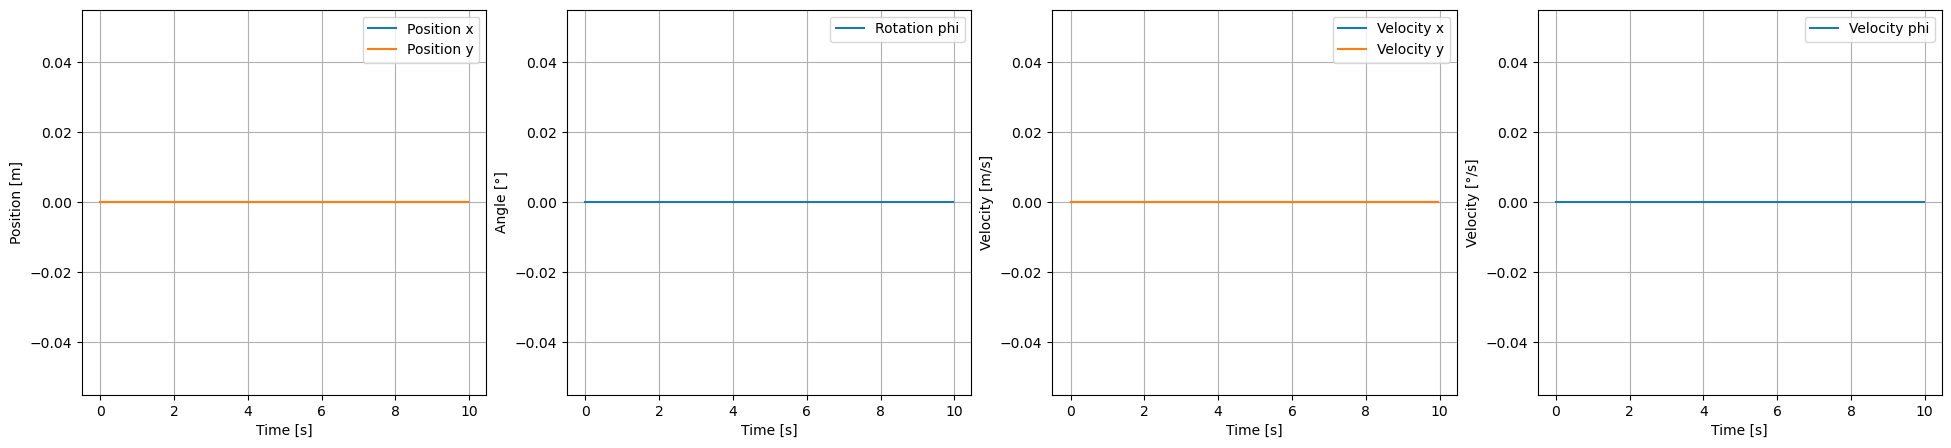

In [22]:
plt.figure(figsize=(24,5))
plt.subplot(141)
plt.plot(time[:-1], states[0,:-1], label='Position x')
plt.plot(time[:-1], states[1,:-1], label='Position y')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend()
plt.grid()

plt.subplot(142)
plt.plot(time[:-1], states[2,:-1]*180/np.pi, label='Rotation phi')
plt.xlabel('Time [s]')
plt.ylabel('Angle [°]')
plt.legend()
plt.grid()

plt.subplot(143)
plt.plot(time[:-1], states[3,:-1], label='Velocity x')
plt.plot(time[:-1], states[4,:-1], label='Velocity y')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid()

plt.subplot(144)
plt.plot(time[:-1], states[5,:-1]*180/np.pi, label='Velocity phi')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [°/s]')
plt.legend()
plt.grid()

plt.show()